### Description
This notebook was used to create a custom plot scheme to represent depth, location, sample replicates, and an additional variable at SBNMS sites

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np

#### Read data

In [2]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv('../data/concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
date_form = DateFormatter("%m/%y")

In [3]:
# All data whose STAT_ID begins with 'S'
s = data[(data['EVENT_ID'] == 'SBNMS')
& (data['TA in (mmol/kgSW)'].notnull())
& (data['TCO2 in (mmol/kgSW)'].notnull())]

# If the row is a field replicate, drop it and keep the last one
no_dupes = s.drop_duplicates(subset=['PROF_DATE_TIME_LOCAL', 'DEPTH (m)'], keep='last')

# Split the data by Depth code
min_depth = no_dupes[no_dupes['DEPTH (m)'] < 2]
max_depth = no_dupes[no_dupes['DEPTH (m)'] > 20]

#### Define custom markers

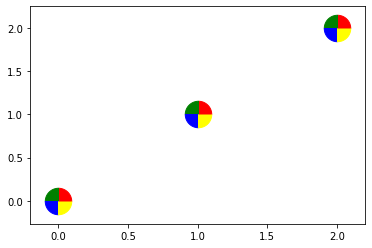

In [4]:
#Define markers

# Shallow marker
x1 = np.cos(np.linspace(0, np.pi / 2))
y1 = np.sin(np.linspace(0, np.pi / 2))
top_right = np.row_stack([[0, 0], np.column_stack([x1, y1])])

# Shallow dupe marker
x2= np.cos(np.linspace(np.pi / 2, np.pi))
y2 = np.sin(np.linspace(np.pi / 2, np.pi))
top_left = np.row_stack([[0, 0], np.column_stack([x2, y2])])

# Deep marker
x3 = np.cos(np.linspace(np.pi, 3 * np.pi / 2))
y3 = np.sin(np.linspace(np.pi, 3 * np.pi / 2))
bottom_left = np.row_stack([[0, 0], np.column_stack([x3, y3])])

# Deep dupe marker
x4 = np.cos(np.linspace(3 * np.pi / 2, 2 * np.pi))
y4 = np.sin(np.linspace(3 * np.pi / 2, 2 * np.pi))
bottom_right = np.row_stack([[0, 0], np.column_stack([x4, y4])])

fig, ax = plt.subplots()
# Scatter shallow
ax.scatter(range(3), range(3), marker=top_right, s=700, facecolor='red')
# Scatter shallow dupe
ax.scatter(range(3), range(3), marker=top_left, s=700, facecolor='green')
# Scatter deep
ax.scatter(range(3), range(3), marker=bottom_left, s=700, facecolor='blue')
# Scatter deep dupe
ax.scatter(range(3), range(3), marker=bottom_right, s=700, facecolor='yellow')

plt.show()

### Format data

In [5]:
variable = 'TCO2 in (mmol/kgSW)'

In [6]:
# Format the data for graphing method 2
by_station_out = pd.DataFrame(columns = ['STAT_ID', 'LATITUDE', 'LONGITUDE', 'TOP_LEFT', 'TOP_RIGHT', 'BOTTOM_RIGHT', 'BOTTOM_LEFT'])

row = 0
by_station = s.groupby('STAT_ID')
for name, group in by_station:
    lat = group.iloc[0]['LATITUDE']
    lon = group.iloc[0]['LONGITUDE']

    by_station_out.loc[row, 'LATITUDE'] = lat

    by_station_out.loc[row, 'LONGITUDE'] = lon

    by_station_out.loc[row, 'STAT_ID'] = name

    shallow = group[group['DEPTH (m)'] < 3]
    deep = group[group['DEPTH (m)'] > 19]

      #print(shallow)
    if len(shallow) == 1:
        by_station_out.loc[row, 'TOP_LEFT'] = shallow.iloc[0][variable]
        by_station_out.loc[row, 'TOP_RIGHT'] = shallow.iloc[0][variable]
    elif len(shallow) == 2:
        by_station_out.loc[row, 'TOP_LEFT'] = shallow.iloc[0][variable]
        by_station_out.loc[row, 'TOP_RIGHT'] = shallow.iloc[1][variable]
    
    if len(deep) == 1:
        by_station_out.loc[row, 'BOTTOM_LEFT'] = deep.iloc[0][variable]
        by_station_out.loc[row, 'BOTTOM_RIGHT'] = deep.iloc[0][variable]
    elif len(deep) == 2:
        by_station_out.loc[row, 'BOTTOM_LEFT'] = deep.iloc[0][variable]
        by_station_out.loc[row, 'BOTTOM_RIGHT'] = deep.iloc[1][variable]
        
    row += 1

In [7]:
# Drop the nans
top_left_data = by_station_out.dropna(subset=['TOP_LEFT'])
top_right_data = by_station_out.dropna(subset=['TOP_RIGHT'])
bottom_left_data = by_station_out.dropna(subset=['BOTTOM_LEFT'])
bottom_right_data = by_station_out.dropna(subset=['BOTTOM_RIGHT'])

### Create the plot

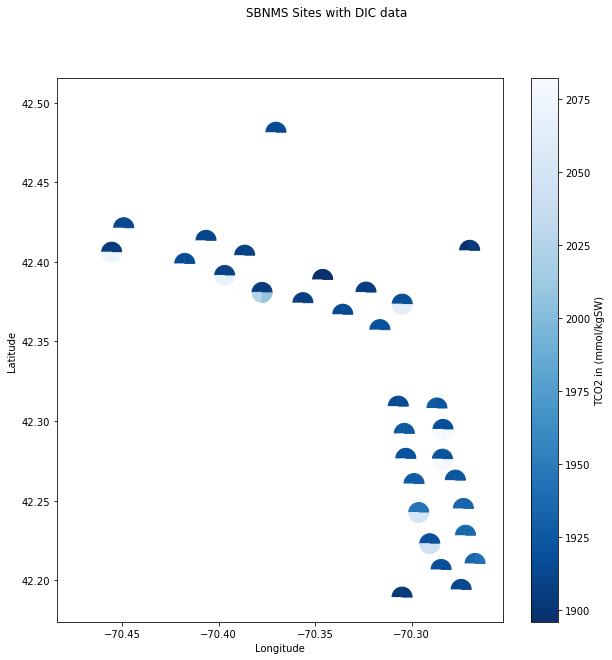

In [8]:
# Fill the whole circle if a shallow/deep is not available, use different color scale for each
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.suptitle('SBNMS Sites with DIC data')

# Get the max and min DIC values
min_var = s[variable].min()
max_var =  s[variable].max()

# Plot the shallow segments
s1 = ax.scatter(
  top_left_data['LONGITUDE'],
   top_left_data['LATITUDE'],
    c=top_left_data['TOP_LEFT'],
     vmin=min_var,
      vmax = max_var,
       cmap = 'Blues_r',
        marker=top_left,
         s = 400)
         
s2 = ax.scatter(
  top_right_data['LONGITUDE'],
   top_right_data['LATITUDE'],
    c=top_right_data['TOP_RIGHT'],
     vmin=min_var,
      vmax = max_var,
       cmap = 'Blues_r',
        marker=top_right,
         s = 400)

s3 = ax.scatter(
  bottom_left_data['LONGITUDE'],
    bottom_left_data['LATITUDE'],
      c=bottom_left_data['BOTTOM_LEFT'],
        vmin=min_var,
          vmax = max_var,
            cmap = 'Blues_r',
              marker=bottom_left,
                s = 400)

s4 = ax.scatter(
  bottom_right_data['LONGITUDE'],
    bottom_right_data['LATITUDE'],
      c=bottom_right_data['BOTTOM_RIGHT'],
        vmin=min_var,
          vmax = max_var,
            cmap = 'Blues_r',
              marker=bottom_right,
                s = 400)
# Set the colorbar

cbar1 = plt.colorbar(s1, ax=ax)
cbar1.set_label(variable)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()